In [7]:
import sumolib
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import xml.etree.ElementTree as ET
import random

import torch
import torch_geometric
import torch_geometric.data as Data
import torch_geometric.utils as pyg_utils

import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv
import numpy as np
import json
import sys



First let's read in the graph file and see if it works properly

## Data handling

In [2]:
#Function to read in the network we work with into a networkx object with the nodes and edges, no features yet
def read_sumo_net(filename):
    net = sumolib.net.readNet(filename)
    G = nx.Graph()
    
    # Add nodes
    for node in net.getNodes():
        G.add_node(node.getID(), pos=(node.getCoord()))
    # Add edges
    for edge in net.getEdges():
        for lane in edge.getLanes():
            edge_id = lane.getEdge().getID()
            starting_node_id = net.getEdge(edge_id).getFromNode().getID()
            ending_node_id = net.getEdge(edge_id).getToNode().getID()
            G.add_edge(starting_node_id, ending_node_id, edge_id = edge_id)
    return G

#Function to add the features to the network graph we created already

def add_edge_features_from_xml(G, xml_filename, interval_begin):
    # Parse the XML file
    tree = ET.parse(xml_filename)
    root = tree.getroot()
    #Find the interval corresponding to the interval_begin time 
    interval = root.find(f'.//interval[@begin="{interval_begin}"]')
    #Extract all the features of the edges
    edges = interval.findall('.//edge')
    for edge in edges:
        edge_id = edge.get('id')
        edge_features = {}
        edge_features['left'] = edge.get('left')
        #We can add other features here
        #Iterate through the edges in the existing NetworkX graph
        for xml_edge_id, xml_edge_data in G.edges.items():
            if G.get_edge_data(xml_edge_id[0],xml_edge_id[1])['edge_id'] == edge_id:
                G.edges[xml_edge_id].update(edge_features)
    return G

def nx_to_pyg(graph):
    # Convert NetworkX graph to PyTorch Geometric Data object
    pyg_data = Data.Data()
    #We have to number the nodes, because that is how Data object works
    # Mapping between string node IDs and numerical indices
    node_id_to_index = {node_id: i for i, node_id in enumerate(graph.nodes)}

    # Set node features
    num_nodes = graph.number_of_nodes()
    node_features = np.zeros((num_nodes, 2))  # Assuming num_features is known, this is important to change, if we want to change something, altough I do not think that will be the case for us
    for i, (node, features) in enumerate(graph.nodes(data=True)):
        node_features[i] = [features['pos'][0], features['pos'][1]]  # Add node features accordingly, this case the coordinates
    pyg_data.x = torch.tensor(node_features, dtype=torch.float)

    # Set edge features and edge indices
    edge_index = []
    edge_features = []
    for u, v, features in graph.edges(data=True):
        # Map string node IDs to numerical indices
        u_index = node_id_to_index[u]
        v_index = node_id_to_index[v]
        edge_index.append([u_index, v_index])
        edge_features.append([float(features['left'])])  # Add edge features accordingly, if we add more features, we have to change this line

    pyg_data.edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    pyg_data.edge_attr = torch.tensor(edge_features, dtype=torch.float)

    return pyg_data


#Function to plot the graph
def plot_graph(G):
    pos = nx.get_node_attributes(G, 'pos')
    nx.draw(G, pos, with_labels=False, node_size=1)
    plt.show()


def data_preparation(data, edges_to_hide):
    prepared_training_data = []
    prepared_test_data = []
    summa = 0
    for graph in data:
        edge_features = graph.edge_attr
        max_value = edge_features.max()
        normalized_edge_features = edge_features / max_value
        graph.edge_attr = normalized_edge_features
        graph_test = graph.clone()
        edge_features_to_sum = graph_test.edge_attr
        squared_edge_features = edge_features_to_sum**2
        summa += squared_edge_features.mean()
        graph.edge_attr[edges_to_hide] = -1
        prepared_training_data.append(graph)
        prepared_test_data.append(graph_test)

    return prepared_training_data, prepared_test_data, summa/len(data)

def evaluate_all_graphs(model, prepared_training_data, prepared_test_data, edges_to_hide, criterion):
    total_loss = 0
    for i in range(len(prepared_training_data)):
        output = model(prepared_training_data[i].edge_attr, prepared_training_data[i].edge_index)
        loss = criterion(output[edges_to_hide], prepared_test_data[i].edge_attr[edges_to_hide])
        total_loss += loss
    return total_loss/len(prepared_training_data)


Graph = read_sumo_net('s_gyor.net.xml')


Data(x=[413, 2], edge_index=[2, 504], edge_attr=[504, 1])


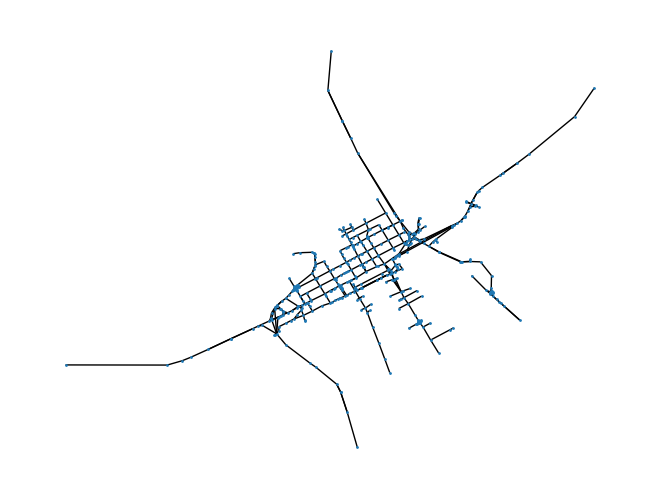

In [3]:
G1 = read_sumo_net('s_gyor.net.xml')
G2 = add_edge_features_from_xml(G1,'gyor_forg_15_min.xml',"0.00")
pyg_data = nx_to_pyg(G2)
print(pyg_data)
plot_graph(G1)

## Model

In [4]:

class GNN(nn.Module):
    def __init__(self, edge_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, hidden_dim6, hidden_dim7, hidden_dim8):
        super(GNN, self).__init__()
        self.conv1 = GCNConv(edge_dim, hidden_dim1)
        self.conv2 = GCNConv(hidden_dim1, hidden_dim2)
        self.conv3 = GCNConv(hidden_dim2, hidden_dim3)
        self.conv4 = GCNConv(hidden_dim3, hidden_dim4)
        self.conv5 = GCNConv(hidden_dim4, hidden_dim5)
        self.conv6 = GCNConv(hidden_dim5, hidden_dim6)
        self.conv7 = GCNConv(hidden_dim6, hidden_dim7)
        self.conv8 = GCNConv(hidden_dim7, hidden_dim8)
        self.linear = nn.Linear(hidden_dim8, edge_dim)

    def forward(self, edge_features, edge_index):
        x = self.conv1(edge_features, edge_index)
        x = F.relu(x)
        x = self.conv2(x, edge_index)
        x = F.relu(x)
        x = self.conv3(x, edge_index)
        x = F.relu(x)
        x = self.conv4(x, edge_index)
        x = F.relu(x)
        x = self.conv5(x, edge_index)
        x = F.relu(x)
        x = self.conv6(x, edge_index)
        x = F.relu(x)
        x = self.conv7(x, edge_index)
        x = F.relu(x)
        x = self.conv8(x, edge_index)
        x = F.relu(x)
        x = self.linear(x)
        return x

## Initialization of the model

In [11]:
G2 = add_edge_features_from_xml(G1,'gyor_forg_15_min.xml',"10800.00")
with open('edges_to_hide.json', 'r') as file:
    edges_to_hide = json.load(file)
data = torch.load('data.pth')

prepared_training_data, prepared_test_data, summa = data_preparation(data, edges_to_hide)
print(summa)


# Define the model
edge_dim = 1  # Number of edge features
hidden_dim1 = 32
hidden_dim2 = 128
hidden_dim3 = 64
hidden_dim4 = 32
hidden_dim5 = 32
hidden_dim6 = 32
hidden_dim7 = 32
hidden_dim8 = 32

model = GNN(edge_dim, hidden_dim1, hidden_dim2, hidden_dim3, hidden_dim4, hidden_dim5, hidden_dim6, hidden_dim7, hidden_dim8)

criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.005)

num_epochs = 10000
losses = []
total_losses = []
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    if epoch % 100 == 0:
        i = random.randint(0, len(prepared_test_data)-1)
    # Forward pass
    output = model(prepared_training_data[i].edge_attr, prepared_training_data[i].edge_index)
    
    # Compute loss using the predicted features and the input features of the hidden edges
    loss = criterion(output[edges_to_hide], prepared_test_data[i].edge_attr[edges_to_hide])
    losses.append(float(loss))
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(f'Epoch {epoch+1}, Loss: {loss.item()}')
        total_loss = evaluate_all_graphs(model, prepared_training_data, prepared_test_data, edges_to_hide, criterion)
        total_losses.append(float(total_loss))
    print(sys.getsizeof(losses))
    print(sys.getsizeof(total_losses))

#plot_graph_weight(G2) 
with open('total_losses.json', 'w') as file:
    json.dump(total_losses, file)
with open('losses.json', 'w') as file:
    json.dump(losses, file)

tensor(0.0980)
Epoch 1, Loss: 0.20992526412010193
88
88
88
88
88
88
88
88
120
88
120
88
120
88
120
88
184
88
184
88
184
88
184
88
184
88
184
88
184
88
184
88
248
88
248
88
248
88
248
88
248
88
248
88
248
88
248
88
312
88
312
88
312
88
312
88
312
88
312
88
312
88
312
88
376
88
376
88
376
88
376
88
376
88
376
88
376
88
376
88
472
88
472
88
472
88
472
88
472
88
472
88
472
88
472
88
472
88
472
88
472
88
472
88
568
88
568
88
568
88
568
88
568
88
568
88
568
88
568
88
568
88
568
88
568
88
568
88
664
88
664
88
664
88
664
88
664
88
664
88
664
88
664
88
664
88
664
88
664
88
664
88
792
88
792
88
792
88
792
88
792
88
792
88
792
88
792
88
792
88
792
88
792
88
792
88
792
88
792
88
792
88
792
88
920
88
920
88
920
88
920
88
920
88
920
88
920
88
920
88
Epoch 101, Loss: 0.056524574756622314
920
88
920
88
920
88
920
88
920
88
920
88
920
88
920
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88
1080
88


1358


In [12]:
torch.save(model.state_dict(), 'gnn_model.pth')
layers = [model.conv1, model.conv2, model.conv3, model.conv4, model.conv5, model.conv6, model.conv7, model.conv8]
edge_dims = []
for layer in layers:
    edge_dims.append(layer.in_channels)
edge_dims.append(model.linear.in_features)
with open('dimensions.json','w') as file:
    json.dump(edge_dims, file)


## Loading the model
Once we trained it nd saved it, this is how we can load it

In [33]:
with open('dimensions.json', 'r') as file:
    edge_dims = json.load(file)

model2 = GNN(edge_dims[0], edge_dims[1], edge_dims[2], edge_dims[3], edge_dims[4], edge_dims[5], edge_dims[6], edge_dims[7], edge_dims[8])
model2.load_state_dict(torch.load('gnn_model.pth'))


<All keys matched successfully>

In [13]:
def make_an_estimation(edges_to_hide, model, data_training):
    edge_features = data_training.edge_attr
    max_value = edge_features.max()
    normalized_edge_features = edge_features / max_value
    data_training.edge_attr = normalized_edge_features
    output = model(data_training.edge_attr, data_training.edge_index)
    loss = criterion(output[edges_to_hide], data_testing.edge_attr[edges_to_hide])
    return loss, output

G3 = add_edge_features_from_xml(G1,'gyor_forg_15_min.xml',"9000.00")
data_training2 = nx_to_pyg(G3)
make_an_estimation(edges_to_hide, model, data_training2)

NameError: name 'data_testing' is not defined

## Data visualization

In [22]:
def losses_epoch_plot(losses, save, save_name):
    fig = plt.figure()
    epochs = np.linspace(start=0, stop=np.size(losses), num=np.size(losses))
    plt.scatter(epochs,losses,c='red')
    plt.ylabel('Loss', fontsize=20)
    plt.xlabel('Epochs', fontsize=20)
    plt.grid(True,which='major',color='gray')
    plt.minorticks_on()
    plt.tick_params(axis='both', which='both', direction= 'in')
    plt.ylim([0,0.2])
    fig.set_size_inches(14,7.5)
    if save:
        plt.savefig(save_name)



def enhanced_histogram(data, bins=30, save=False, save_name='histogram.png'):
    fig = plt.figure()
    plt.hist(data, bins=bins, color='blue', edgecolor='black')
    plt.ylabel('Frequency', fontsize=20)
    plt.xlabel('Difference', fontsize=20)  # Changed to 'Difference' to reflect the data
    plt.grid(True, which='major', color='gray', linestyle='--', linewidth=0.7)
    plt.minorticks_on()
    plt.grid(True, which='minor', color='lightgray', linestyle=':', linewidth=0.5)
    plt.tick_params(axis='both', which='both', direction='in', top=True, right=True)
    fig.set_size_inches(14, 7.5)
    plt.title('Histogram of Differences', fontsize=22)  # Changed title to reflect the data

    if save:
        plt.savefig(save_name)
    plt.show()



352


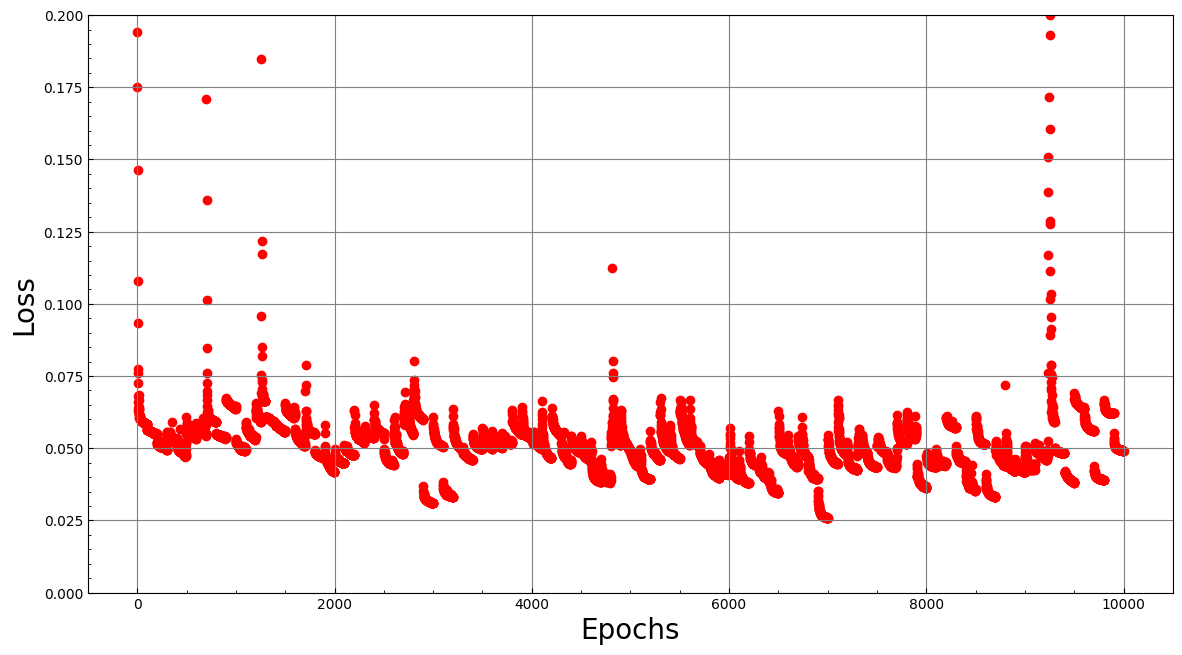

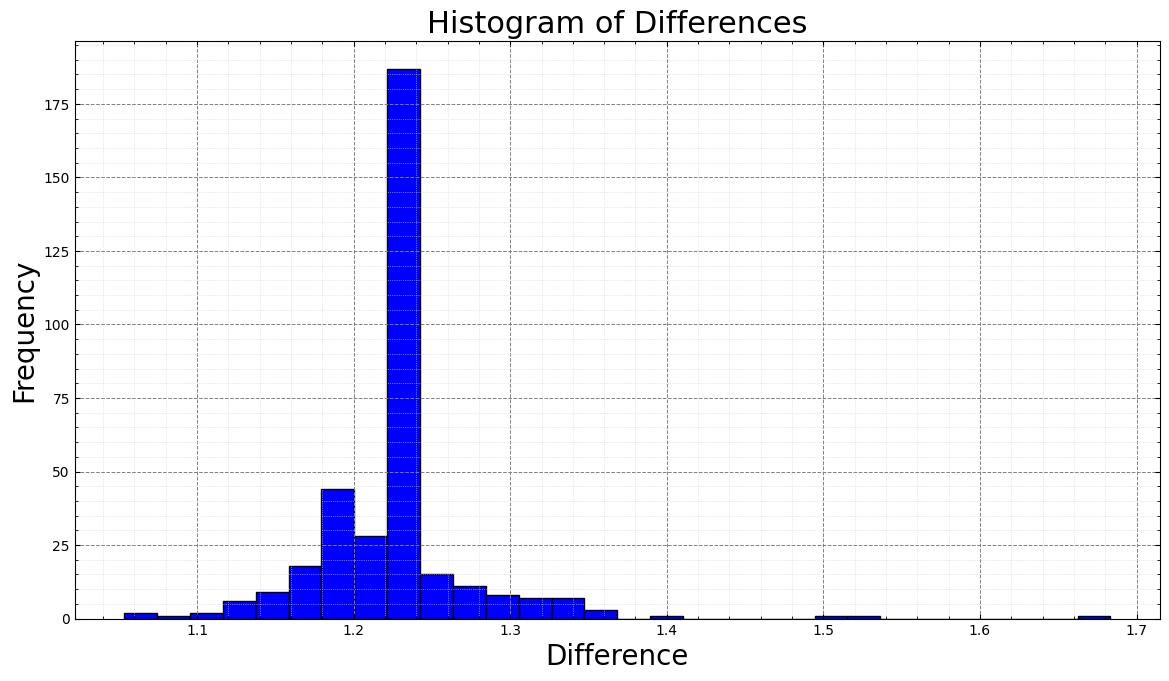

[1.24814665 1.2733109  1.22390676 1.19995105 1.23124075 1.24353778
 1.22390676 1.22390676 1.24967539 1.1255132  1.25628459 1.05612099
 1.22390676 1.22112632 1.33486104 1.22390676 1.2201364  1.15864658
 1.22390676 1.25209475 1.1562984  1.16719019 1.22390676 1.20897448
 1.22390676 1.25090981 1.23398888 1.22390676 1.22390676 1.68337071
 1.1857065  1.25617611 1.29839766 1.22390676 1.21619332 1.23398888
 1.23398888 1.17693114 1.21589303 1.22390676 1.15845287 1.22390676
 1.22390676 1.17114556 1.11299777 1.29839766 1.17789114 1.15445387
 1.22390676 1.22390676 1.22390676 1.22390676 1.22390676 1.19730103
 1.22390676 1.17590415 1.21622276 1.29675293 1.16146529 1.22390676
 1.19989264 1.19137883 1.19895971 1.13012064 1.22390676 1.19771874
 1.21589303 1.22390676 1.23398888 1.22390676 1.23398888 1.34559262
 1.20047605 1.16072834 1.21999919 1.182724   1.22390676 1.22390676
 1.22390676 1.22390676 1.15878701 1.22390676 1.19730103 1.22390676
 1.22390676 1.22816133 1.20091808 1.22390676 1.22390676 1.2063

In [23]:
losses_epoch_plot(losses,False,'asd')

N = 352
print(N)
difference = np.zeros(N)
output = model(prepared_training_data[2].edge_attr, prepared_training_data[2].edge_index)
for j in range(N):
    if output[edges_to_hide][j]<0:
        output[edges_to_hide][j] = 0
    difference[j] = float(abs(output[edges_to_hide][j] - prepared_training_data[2].edge_attr[edges_to_hide][j]))
    #print(output[edges_to_hide][i])
enhanced_histogram(difference, bins=30, save=False, save_name='enhanced_histogram.png')
print(difference)

352
[(1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0, 0.0, 1.0, 1.0), (1.0,

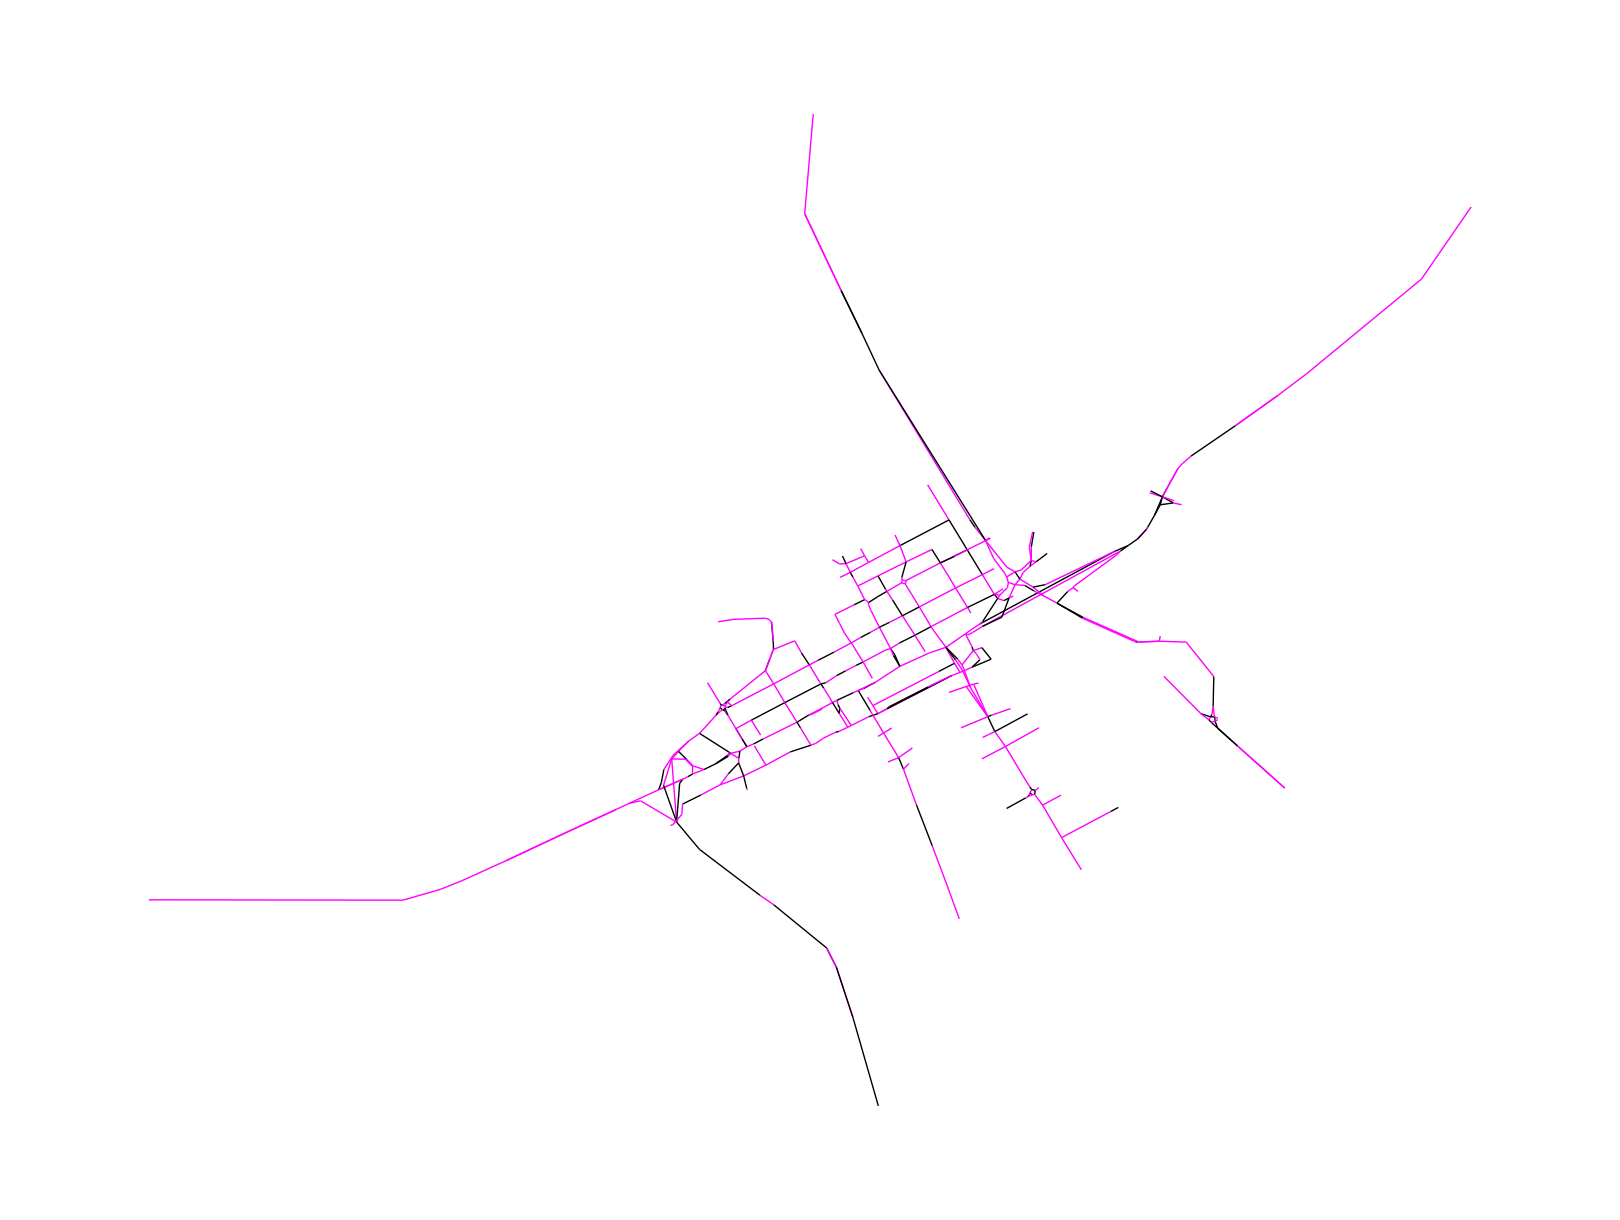

In [11]:
def plot_graph_weight(G):
    plt.figure(figsize=(16,12))
    pos = nx.get_node_attributes(G, 'pos')
    N = num_edges_to_hide
    print(N)
    difference = np.zeros(N)
    for i in range(N):
        if output[edges_to_hide][i]<0:
            output[edges_to_hide][i] = 0
        difference[i] = float(abs(output[edges_to_hide][i] - data_testing.edge_attr[edges_to_hide][i]))

    maxdiff = max(difference)

    cmap = matplotlib.colors.LinearSegmentedColormap.from_list("", ["magenta", "magenta", "magenta"])
    colors = [cmap(c/maxdiff) for c in difference]
    
    print(colors)

    edge_colors = {edge: 'black' for edge in G.edges()}


    edges_to_color_edges = []
    edges=list(G2.edges())
    edges_to_color_by_id=[]

    for i in edges_to_hide:
        edges_to_color_edges.append(edges[i])
    for i in edges_to_color_edges:
        edges_to_color_by_id.append(G2.edges[i]['edge_id'])

    colorindexiter=0
    for edge in G.edges():
        edge_id = G.edges[edge]['edge_id']


        if edge_id in edges_to_color_by_id:

            edge_colors[edge] = colors[colorindexiter]
            colorindexiter+=1

    nx.set_edge_attributes(G, edge_colors, 'color')

    edge_color_values = [G[u][v]['color'] for u, v in G.edges()]
    options = {
        

        "width": 1,
        "edge_cmap": plt.cm.Blues,
        "with_labels": False,
    }
    nx.draw(G, pos, **options, edge_color=edge_color_values, node_size=0) 

    plt.show()
    
plot_graph_weight(G2) 